In [6]:
from google.colab import output
output.enable_custom_widget_manager()

In [7]:
!pip install ipympl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.0 MB/s eta 0:00:00


In [8]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

In [109]:
class Detector:
    def __init__(self, position, name):
        self.name = f'detector {name}'
        self.position = np.asarray(position)
        self.lab_frame_axes = np.array(((1,0,0),(0,1,0),(0,0,1)))
    def __repr__(self):
        return self.name

class Source:
    def __init__(self, position):
        self.name = 'source'
        self.position = np.asarray(position)
    def __repr__(self):
        return self.name

class Sample:
    def __init__(self, position, orientation, cell_parameters, q_range, cell_orientations, cell_colors=None):
        '''
        position: lab frame x,y,z coordiantes
        orientation: sample
        '''
        self.name = 'sample'
        self.position = np.asarray(position)
        self.orient_array = orientation
        self.cell_parameters = cell_parameters
        self.a, self.b, self.c = cell_parameters
        self.v = self.a*self.b*self.c
        self.q_range = q_range
        self.cell_orientations = [Rotation.from_euler('ZXZ', co) for co in cell_orientations]
        self.get_reciprocal_lattice_vectors()
        self.generate_reciprocal_lattice_to_q()
        self.orient_reciprocal_lattices_to_sample()
        if cell_colors == None:
            self.cell_colors = ['black']*len(cell_orientations)
        else:
            self.cell_colors = cell_colors
        self.update()
    def __repr__(self):
        return self.name
    def get_view_in_lab_frame(self, view_axis):
        return self.rot.apply(view_axis)
    def update(self):
        self.rot = Rotation.from_euler('ZXZ', self.orient_array, degrees = True)
        self.lab_frame_axes = self.rot.as_matrix()
        self.orient_reciprocal_lattices_to_lab()
    def get_reciprocal_lattice_vectors(self):
        a, b, c = np.array((self.a,0,0)), np.array((0,self.b,0)), np.array((0,0,self.c))
        v = self.v
        astar = np.cross(b,c)/v
        bstar = np.cross(c,a)/v
        cstar = np.cross(a,b)/v
        self.astar = astar[0]
        self.bstar = bstar[1]
        self.cstar = cstar[2]
    def generate_reciprocal_lattice_to_q(self):
        arange = np.ceil(self.q_range / self.astar)
        brange = np.ceil(self.q_range / self.bstar)
        crange = np.ceil(self.q_range / self.cstar)
        astar_inds = np.arange(-arange, arange+1)
        bstar_inds = np.arange(-brange, brange+1)
        cstar_inds = np.arange(-crange, crange+1)
        span = int((2*arange+1)*(2*brange+1)*(2*crange+1))
        astars = astar_inds*self.astar
        bstars = bstar_inds*self.bstar
        cstars = cstar_inds*self.cstar
        self.reciprocal_lattice = np.asarray(np.meshgrid(astars,bstars,cstars)).reshape((3, span))
    def orient_reciprocal_lattices_to_sample(self):
        self.sample_space_rlatts = [co.apply(self.reciprocal_lattice.T).T for co in self.cell_orientations]
    def orient_reciprocal_lattices_to_lab(self):
        self.lab_space_rlatts = [self.rot.apply(rl.T).T for rl in self.sample_space_rlatts]





class SphereConstructions():
    def __init__(self, source, detectors, sample, ewald_radii, pole_radius, sample_view_axis, detector_colors = None):
        self.source = source
        self.detectors = detectors
        if detector_colors == None:
            self.detector_colors = ['black']*len(detectors)
        else:
            self.detector_colors = detector_colors
        self.sample = sample
        self.ewald_radii = ewald_radii
        self.ewald_radius = ewald_radii[0]
        self.pole_radius = pole_radius
        self.sample_view_axis = np.asarray(sample_view_axis)
        self.update()
        self.setup_view()

    def update(self):
        self.pole_view_axis = self.sample.get_view_in_lab_frame(self.sample_view_axis)
        self.north_pole = self.pole_view_axis/np.linalg.norm(self.pole_view_axis)
        self.south_pole = -self.north_pole


        self.ki_raw = self.sample.position - self.source.position
        self.ki = self.ki_raw/np.linalg.norm(self.ki_raw)

    def get_sphere_cart_array(self, r = 1, res = 100, offset=(0,0,0)):
        u = np.linspace(0, 2 * np.pi, res)
        v = np.linspace(0, np.pi, res)
        x = r*np.outer(np.cos(u), np.sin(v)) + offset[0]
        y = r*np.outer(np.sin(u), np.sin(v))+ offset[1]
        z = r*np.outer(np.ones(np.size(u)), np.cos(v))+ offset[2]
        return np.concatenate((x[None,:],y[None,:],z[None,:]), axis = 0)

    def plot_sphere(self, fig = None, ax = None, cart_array = None):
        # Plot the surface
        x,y,z = cart_array
        ax.plot_surface(x, y, z, color='grey', alpha = 0.25)

        # Set an equal aspect ratio
        ax.set_aspect('equal')

    def plot_line(self, fig = None, ax = None, cart_array = None):
        # Plot the surface
        x,y,z = cart_array
        ax.plot(x, y, z, color='grey', alpha = 1)


    def cuboid_data(self,center, size, rotation_matrix):
        """
        Generate the X, Y, Z coordinates for a cuboid.

        Parameters:
            center: tuple of 3 floats
                Coordinates of the cuboid's center (Px, Py, Pz).
            size: tuple of 3 floats
                Dimensions of the cuboid (a, b, c).
            rotation_matrix: 3x3 numpy array
                Rotation matrix to orient the cuboid.

        Returns:
            X, Y, Z: 2D numpy arrays
                Coordinates for the cuboid's surface.
        """
        # Extract cuboid size
        a, b, c = size
        # Generate corner points of the cuboid in local coordinates
        x = np.array([-0.5, 0.5]) * a
        y = np.array([-0.5, 0.5]) * b
        z = np.array([-0.5, 0.5]) * c
        # Create a meshgrid for the cuboid
        x, y, z = np.meshgrid(x, y, z, indexing="ij")

        # Flatten and combine into an array of points
        points = np.array([x.flatten(), y.flatten(), z.flatten()]).T

        # Apply the rotation
        rotated_points = points @ rotation_matrix.T

        # Translate to the center
        translated_points = rotated_points + np.array(center)

        # Reshape into 2D arrays for plotting
        X = translated_points[:, 0].reshape(2, 2, 2)
        Y = translated_points[:, 1].reshape(2, 2, 2)
        Z = translated_points[:, 2].reshape(2, 2, 2)

        return X, Y, Z

    def draw_cube(self, fig = None, ax = None, size = (0.1, 0.1, 0.1), offset = (0,0,0)):
        X,Y,Z = self.cuboid_data(offset, size, self.sample.lab_frame_axes)
        for i in range(2):  # Bottom/Top faces
            ax.plot_surface(X[i, :, :], Y[i, :, :], Z[i, :, :], alpha=0.5, color='blue')
        for i in range(2):  # Front/Back faces
            ax.plot_surface(X[:, i, :], Y[:, i, :], Z[:, i, :], alpha=0.5, color='green')
        for i in range(2):  # Left/Right faces
            ax.plot_surface(X[:, :, i], Y[:, :, i], Z[:, :, i], alpha=0.5, color='red')


    def get_detector_Ks(self):
        Ks = [source.position - det.position for det in self.detectors]
        Gs = []
        for K in Ks:
            roots = self.sphere_line_intercept(np.zeros(3), K, -self.ki*self.ewald_radius, self.ewald_radius)
            Gs.append(roots[roots!=0]*K)
        return np.asarray(Gs)

    def setup_view(self):
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(projection='3d')

    def calc_ewald(self):
        self.es_cart_array = self.get_sphere_cart_array(r = self.ewald_radius, offset = -self.ki*self.ewald_radius)
        Ks = self.get_detector_Ks()
        self.Ks = Ks

    def show_sample(self, ratio = 0.1):
        fig = self.fig
        ax = self.ax
        self.draw_cube(fig, ax, offset = (0,0, 0), size = self.ewald_radius*np.ones(3)*ratio)


    def show_ewald(self):
        fig = self.fig
        ax = self.ax
        self.calc_ewald()
        self.plot_sphere(fig,ax, self.es_cart_array)
        for i, K in enumerate(self.Ks):
            ax.quiver(0,0,0, K[0], K[1], K[2], arrow_length_ratio = 0.05, color = self.detector_colors[i])
        for i,rl in enumerate(self.sample.lab_space_rlatts):
            ax.scatter(xs=rl[0], ys= rl[1], zs= rl[2], s =1, c=self.sample.cell_colors[i])

    def calc_pole(self):
        self.pole_cart_array = self.get_sphere_cart_array(r = self.pole_radius, offset = (0,0, 0))
        self.eq_cart = self.orient_to_pole(self.equator(), self.pole_view_axis)
        self.pole_Ks = self.get_pole_K_intercepts()
        self.pole_K_projs = np.asarray([self.get_orientated_stereographic_projection(pK) for pK in self.pole_Ks])


    def get_orientated_stereographic_projection(self, point):
        spoint = self.orient_to_pole(point, self.north_pole)
        oppole = np.array((0,0,-np.sign(spoint[2])*self.pole_radius))
        svec = spoint - oppole
        u = -oppole[2]/svec[2]
        proj_point = (u*svec) + oppole
        #print('point ',point, 'spoint ',spoint,'oppole ',oppole, 'svec ', svec, 'proj_point ', proj_point)
        return self.orient_to_pole(proj_point, self.north_pole)


    def show_pole(self):
        fig = self.fig
        ax = self.ax
        self.calc_pole()
        self.plot_sphere(fig,ax, self.pole_cart_array)
        self.plot_line(fig,ax, self.eq_cart)
        for i, K in enumerate(self.pole_Ks):
            ax.quiver(0,0,0, K[0], K[1], K[2], arrow_length_ratio = 0.05, color = self.detector_colors[i])
            proj_vec = self.pole_K_projs[i]-K
            ax.quiver(K[0], K[1], K[2],
                      proj_vec[0], proj_vec[1], proj_vec[2],
                      arrow_length_ratio = 0.05, color = self.detector_colors[i])


    def sphere_line_intercept(self, p1, p2, p3, r):
        """
        p1: one point on line (ideally vector representation of line so this can be (0,0,0)
        p2: another point on line (if vector repr, p2 = vec)
        p3: centre of sphere
        r:  radius of sphere
        """

        a = np.sum((p2-p1)**2)
        b = 2*(np.dot(p2-p1, p1-p3))
        c = np.sum(p3**2) + np.sum(p1**2) - 2*np.dot(p3, p1) - r**2

        roots = np.array((-b+np.sqrt((b**2) - 4*a*c))/(2*a) , (-b-np.sqrt((b**2) - 4*a*c))/(2*a))

        return roots

    def equator(self, r = None, res = 100, offset=(0,0,0)):
        if r == None:
            r = self.pole_radius
        u = np.linspace(0, 2 * np.pi, res)
        x = r*np.cos(u) + offset[0]
        y = r*np.sin(u) + offset[1]
        z = np.zeros_like(x) + offset[2]
        return np.concatenate((x[None,:],y[None,:],z[None,:]), axis = 0)

    def orient_to_pole(self, eq, view_axis):
        bisect = view_axis + ((np.array((0,0,1)) - view_axis)/2)
        bisect = (bisect/np.linalg.norm(bisect))*-np.pi
        rot = Rotation.from_rotvec(bisect)
        return rot.apply(eq.T).T

    def orient_to_pole_new(self, eq, view_axis):
        rot = self.sample.rot
        return rot.apply(eq.T).T


    def get_pole_K_intercepts(self):
        Gs = []
        for K in self.Ks:
            roots = self.sphere_line_intercept(np.zeros(3), K, self.sample.position, self.pole_radius)
            Gs.append(roots[roots!=0]*K)
        return np.asarray(Gs)

    def get_inplane_pole_figure(self):
        self.pole_figure_points = self.sample.rot.apply(self.pole_K_projs, inverse=True)

    def plot_pole_figure(self):
        # add new subplot
        gs0 = self.fig.add_gridspec(3, 1)
        ax_new = self.fig.add_subplot(gs0[1])
        # update and redraw existing axis
        self.ax.set_subplotspec(gs0[0])
        if np.where(self.sample_view_axis ==1)[0] == 0:
            ax_new.scatter(self.pole_figure_points[:,1], self.pole_figure_points[:,2], c = self.detector_colors)
        if np.where(self.sample_view_axis ==1)[0] == 1:
            ax_new.scatter(self.pole_figure_points[:,0], self.pole_figure_points[:,2], c = self.detector_colors)
        if np.where(self.sample_view_axis ==1)[0] == 2:
            ax_new.scatter(self.pole_figure_points[:,0], self.pole_figure_points[:,1], c = self.detector_colors)

        ax_new.set_xlim([-self.pole_radius, self.pole_radius])
        ax_new.set_ylim([-self.pole_radius, self.pole_radius])
        ax_new.set_aspect('equal')

        eq = self.equator()

        ax_new.plot(eq[0], eq[1], c = 'grey')

    def plot_all(self):
        self.update()
        self.ax.clear()
        self.calc_ewald()
        self.show_ewald()
        self.show_sample()
        self.calc_pole()
        self.show_pole()

        self.get_inplane_pole_figure()
        self.plot_pole_figure()






In [110]:
ndet = Detector([0, 10, 0], 'north')
ndet2 = Detector([1, 11, 0], 'north2')
sdet = Detector([0, -10, 0], 'south')
source = Source([10, 0 , 0])
sample = Sample([0,0,0], [30,-45,30], (2,2,2), 0.5, [(0,0,0),])

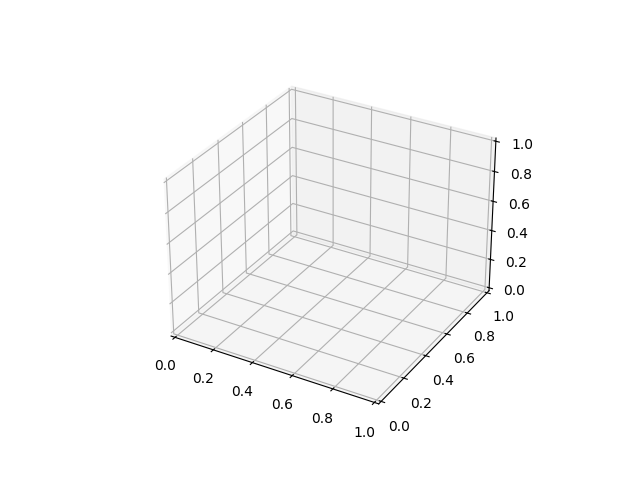

In [111]:
construction_space = SphereConstructions(source, [ndet,ndet2, sdet], sample, (1, 2),1, (1,0,0), detector_colors=('red','green', 'blue'))

In [112]:
construction_space.plot_all()

In [113]:
construction_space.sample.orient_array = (0,0,0)

In [9]:
construction_space.sample.update()

In [10]:
construction_space.plot_all()

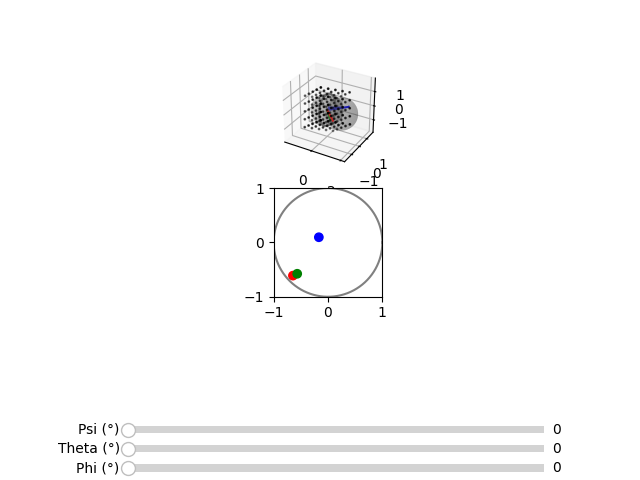

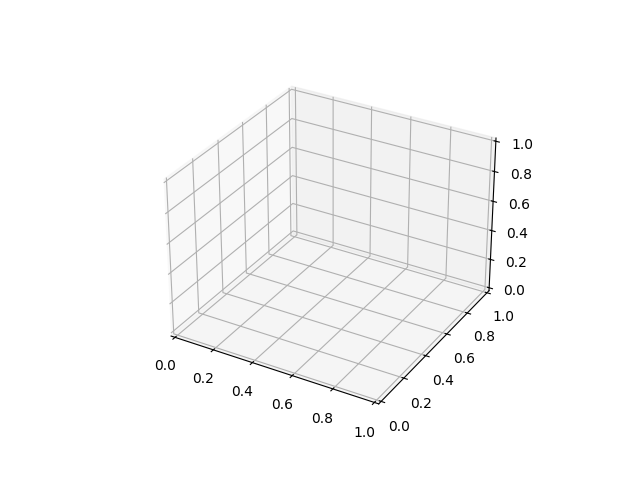

In [115]:
from matplotlib.widgets import Slider

# Create instances of Source, Sample, and SphereConstructions
ndet = Detector([0, 10, 0], 'north')
ndet2 = Detector([1, 11, 0], 'north2')
sdet = Detector([0, -10, 0], 'south')
source = Source([10, 0 , 0])
sample = Sample([0,0,0], [30,-45,30], (2,2,2), 1, [(0,0,0),])

sphere_construction = SphereConstructions(source, [ndet,ndet2, sdet], sample, (1, 2),1, (1,0,0), detector_colors=('red','green', 'blue'))

# Function to update the visualization when sliders change
def update_plot(val):
    # Update the sample's orientation
    sample.orient_array = [slider_phi.val, slider_theta.val, slider_psi.val]
    sample.update()
    sphere_construction.update()
    sphere_construction.plot_all()

# Setup the main figure and axes for visualization
sphere_construction.setup_view()
sphere_construction.plot_all()

# Create sliders below the visualization
fig = sphere_construction.fig
ax_phi = plt.axes([0.2, 0.01, 0.65, 0.03], facecolor='lightgoldenrodyellow')  # Slider for φ
ax_theta = plt.axes([0.2, 0.05, 0.65, 0.03], facecolor='lightgoldenrodyellow')  # Slider for θ
ax_psi = plt.axes([0.2, 0.09, 0.65, 0.03], facecolor='lightgoldenrodyellow')  # Slider for ψ

slider_phi = Slider(ax_phi, 'Phi (°)', 0, 360, valinit=0)
slider_theta = Slider(ax_theta, 'Theta (°)', 0, 360, valinit=0)
slider_psi = Slider(ax_psi, 'Psi (°)', 0, 360, valinit=0)

# Connect sliders to the update function
slider_phi.on_changed(update_plot)
slider_theta.on_changed(update_plot)
slider_psi.on_changed(update_plot)

plt.show()